<a href="https://colab.research.google.com/github/MayongSu/MidTerm-PySpark/blob/main/1301184514_1301184139_Midterm_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [ ]:
# Install Spark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840629 sha256=bd3e0ffdc64a8293c2af293e8226101c6bd06bdfa970e24448003c1e19d970fe
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [ ]:
df=pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv")

In [ ]:
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
55423851,2014-03-15 03:28:00.00000070,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1
55423852,2009-03-24 20:46:20.0000002,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1
55423853,2011-04-02 22:04:24.0000004,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1
55423854,2011-10-26 05:57:51.0000002,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1


In [ ]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("NYC Taxi Fare Prediction") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/18 05:59:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
spark

In [ ]:
# Load the training dataset
train_path = "/kaggle/input/new-york-city-taxi-fare-prediction/train.csv"
train_df = spark.read.csv(train_path, header=True, inferSchema=True)

# Check the schema to confirm data types and structure
train_df.printSchema()


root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [ ]:
# Show the first few rows of the dataset
train_df.show(5)

# Get a summary of the data
train_df.describe().show()


+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:42|        7.7|2012-04-21 04:30:42|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:00|        5.3|2

24/11/18 06:01:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|       fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude|  dropoff_latitude|   passenger_count|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|          55423856|          55423856|         55423856|          55423480|          55423480|          55423856|
|   mean|11.345045601663852|-72.50968444358729| 39.9197917868882|-72.51120972971809|39.920681444828844|1.6853799201556816|
| stddev|  20.7108321982325| 12.84888338140265|9.642353041994934|12.782196517830771| 9.633345796415124|1.3276643570959683|
|    min|            -300.0|      -3442.059565|     -3492.263768|      -3442.024565|      -3547.886698|                 0|
|    max|          93963.36|       3457.625683|      3408.789565|        3457.62235|       3537.132528|               208|
+-------+-------

In [ ]:
# Remove rows with missing values
train_df = train_df.dropna()

# Filter out rows with negative fares or zero passengers
train_df = train_df.filter((train_df.fare_amount > 0) & (train_df.passenger_count > 0))


In [ ]:
from pyspark.sql.functions import radians, cos, sin, asin, sqrt

# Define a function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    return 2 * 6371 * asin(sqrt(sin((lat2 - lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1) / 2)**2))

# Add a new column 'distance' using the Haversine formula
train_df = train_df.withColumn("distance",
                               haversine(radians(train_df.pickup_latitude), radians(train_df.pickup_longitude),
                                         radians(train_df.dropoff_latitude), radians(train_df.dropoff_longitude)))


In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert a sample of the data to Pandas for visualization
sample_df = train_df.sample(fraction=0.01, seed=42).toPandas()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


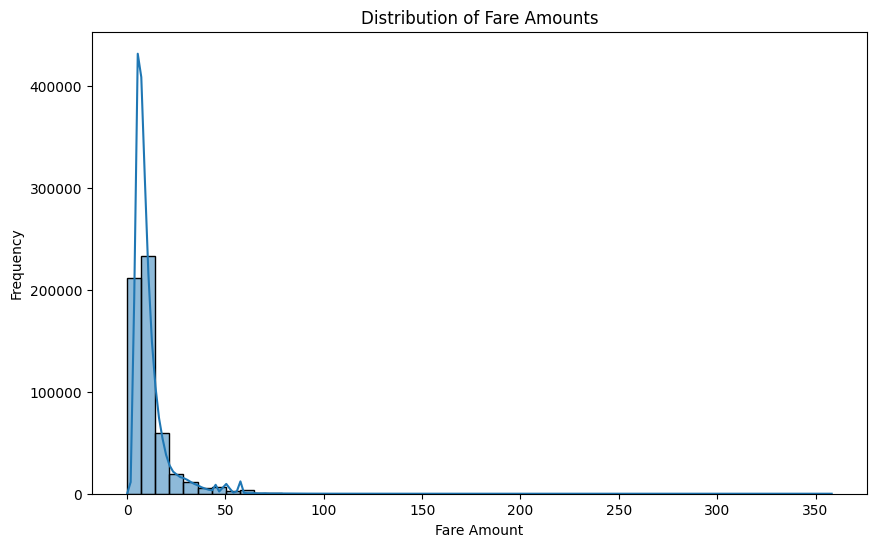

In [ ]:
# Plot fare_amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(sample_df['fare_amount'], bins=50, kde=True)
plt.title("Distribution of Fare Amounts")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


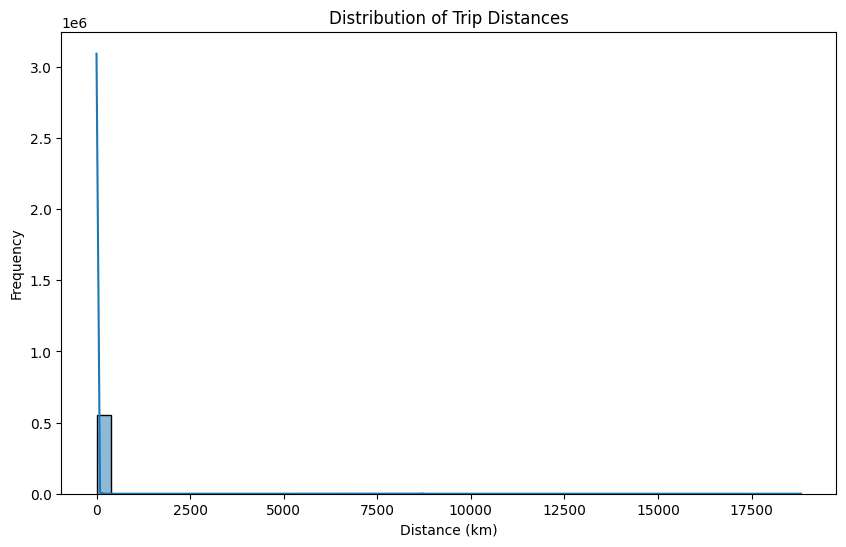

In [ ]:
# Plot distance distribution
plt.figure(figsize=(10, 6))
sns.histplot(sample_df['distance'], bins=50, kde=True)
plt.title("Distribution of Trip Distances")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()

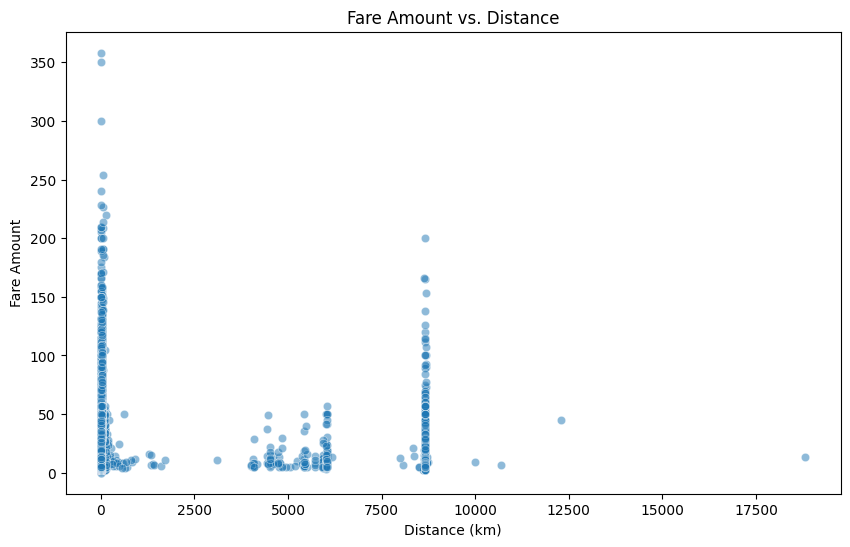

In [ ]:
# Scatter plot of distance vs. fare_amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_df, x='distance', y='fare_amount', alpha=0.5)
plt.title("Fare Amount vs. Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount")
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Select relevant features and target column
feature_columns = ["distance", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "passenger_count"]

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_df = assembler.transform(train_df)

# Split the data into training and testing sets
train_data, test_data = train_df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
# Initialize the GBT Regressor
gbt = GBTRegressor(featuresCol="features", labelCol="fare_amount", maxIter=2)

# Train the model
model = gbt.fit(train_data)

24/11/18 06:13:22 WARN MemoryStore: Not enough space to cache rdd_44_3 in memory! (computed 18.4 MiB so far)
24/11/18 06:13:22 WARN BlockManager: Persisting block rdd_44_3 to disk instead.
24/11/18 06:13:22 WARN MemoryStore: Not enough space to cache rdd_44_2 in memory! (computed 18.4 MiB so far)
24/11/18 06:13:22 WARN BlockManager: Persisting block rdd_44_2 to disk instead.
24/11/18 06:13:22 WARN MemoryStore: Not enough space to cache rdd_44_1 in memory! (computed 27.6 MiB so far)
24/11/18 06:13:22 WARN BlockManager: Persisting block rdd_44_1 to disk instead.
24/11/18 06:13:22 WARN MemoryStore: Not enough space to cache rdd_44_0 in memory! (computed 27.6 MiB so far)
24/11/18 06:13:22 WARN BlockManager: Persisting block rdd_44_0 to disk instead.
24/11/18 06:13:54 WARN MemoryStore: Not enough space to cache rdd_44_4 in memory! (computed 43.6 MiB so far)
24/11/18 06:13:54 WARN MemoryStore: Not enough space to cache rdd_44_5 in memory! (computed 27.6 MiB so far)
24/11/18 06:13:54 WARN Blo

In [ ]:
# Make predictions on the test data
predictions = model.transform(test_data)

# Initialize the evaluator with Root Mean Squared Error (RMSE) as the metric
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

# Calculate RMSE
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 5.37425621081175


In [ ]:
# Calculate Mean Absolute Error (MAE)
mae_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae")
mae = mae_evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")

Mean Absolute Error (MAE) on test data = 2.5876849203522183


In [ ]:
from pyspark.sql.functions import when

# Define fare categories based on prediction values
predictions = predictions.withColumn(
    "fare_category",
    when(predictions["prediction"] < 10, "Low Fare")
    .when((predictions["prediction"] >= 10) & (predictions["prediction"] < 30), "Medium Fare")
    .otherwise("High Fare")
)

# Show a sample of the predictions with fare categories
predictions.select("features", "prediction", "fare_category").show(10)

+--------------------+------------------+-------------+
|            features|        prediction|fare_category|
+--------------------+------------------+-------------+
|[15.1976898981475...| 43.16127658819969|    High Fare|
|[0.74158114372689...| 6.017868660006484|     Low Fare|
|[6.20252857424036...|17.874657864456264|  Medium Fare|
|[1.27378131363886...| 6.347801826763765|     Low Fare|
|[4.54420548906518...|13.195162007893368|  Medium Fare|
|[3.34932053909997...|11.313961684305273|  Medium Fare|
|[0.94865932217737...| 6.177670914995755|     Low Fare|
|[1.81948726321019...|6.5155452676839305|     Low Fare|
|[3.74620294688523...|11.471191955312678|  Medium Fare|
|[2.49181941262547...| 9.482862332908173|     Low Fare|
+--------------------+------------------+-------------+
only showing top 10 rows

